In [1]:
# Install packages: Gymnasium and PyTorch
!pip install gymnasium
!pip install torch

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 953.9/953.9 kB 13.1 MB/s eta 0:00:00


In [2]:
# Import packages
import torch
import random
import gymnasium as gym
from collections import deque
import numpy as np
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import matplotlib.pyplot as plt
from timeit import default_timer as timer
from IPython import display
import time

In [3]:
# Defines the structure of neural network
class DQN(nn.Module):
    def __init__(self, state_dim, action_num):
        super(DQN, self).__init__()
        self.layer1 = nn.Linear(state_dim, 256)
        self.layer2 = nn.Linear(256, 128)
        self.layer3 = nn.Linear(128, 128)
        self.layer4 = nn.Linear(128, action_num)

    def forward(self, x):
        x = F.relu(self.layer1(x))
        x = F.relu(self.layer2(x))
        x = F.relu(self.layer3(x))
        return self.layer4(x)

In [4]:
# DQN agent
class DQNAgent:
    def __init__(self, state_dim, action_num, buffer_size, batch_size, gamma, lr, reduction='mean'):

        # Hyperparameters
        self.state_dim = state_dim              # Shape of observation
        self.action_num = action_num            # Number of actions available
        self.buffer_size = buffer_size          # Size of buffers
        self.batch_size = batch_size            # Batch size
        self.gamma = gamma                      # Discount factor
        self.lr = lr                            # Learning rate
        self.reduction = reduction              # Loss function setting
        self.loss_fn = nn.MSELoss(reduction)    # Loss function

        # Buffers
        self.states_buffer = deque(maxlen=self.buffer_size)
        self.actions_buffer = deque(maxlen=self.buffer_size)
        self.rewards_buffer = deque(maxlen=self.buffer_size)
        self.next_states_buffer = deque(maxlen=self.buffer_size)
        self.dones_buffer = deque(maxlen=self.buffer_size)

        # Networks
        self.local_q = DQN(self.state_dim, self.action_num)             # Main policy network
        self.target_q = DQN(self.state_dim, self.action_num)            # Target network
        self.update_target()                                            # Set target network weight to policy network weight
        self.optimizer = optim.Adam(self.local_q.parameters(), self.lr) # Adam optimizer

    # Given a state, outputs the action with the greatest Q value
    def select_action(self, state):
        q_vals = self.local_q(state)
        action = torch.argmax(q_vals)
        return action

    # Store transition information
    def store(self, state, action, reward, next_state, done):
        self.states_buffer.append(state)
        self.actions_buffer.append(action)
        self.rewards_buffer.append(reward)
        self.next_states_buffer.append(next_state)
        self.dones_buffer.append(done)

    # Set target network weight to policy network weight
    def update_target(self):
        self.target_q.load_state_dict(self.local_q.state_dict())

    # Main training loop
    def train(self):
        # If the number of transitions we have is less than batch_size, we skip training for this time.
        if len(self.states_buffer) < self.batch_size:
            return

        # Sample from buffers
        self.optimizer.zero_grad()
        sample_indices = random.sample(range(len(self.states_buffer)), self.batch_size)
        mini_states = torch.stack([self.states_buffer[i] for i in sample_indices])
        mini_actions = torch.tensor([self.actions_buffer[i] for i in sample_indices], dtype=torch.int32)
        mini_rewards = torch.tensor([self.rewards_buffer[i] for i in sample_indices], dtype=torch.float32)
        mini_next_states = torch.stack([self.next_states_buffer[i] for i in sample_indices])
        mini_dones = torch.tensor([self.dones_buffer[i] for i in sample_indices], dtype=torch.bool)

        # Calculate target values and truth values
        raw_q = self.target_q(mini_next_states)
        max_raw_q, _ = torch.max(raw_q, dim=1)
        y = torch.where(mini_dones, mini_rewards, mini_rewards + self.gamma * max_raw_q)
        raw_x = self.local_q(mini_states)
        x = raw_x[np.arange(self.batch_size), mini_actions]

        # Update network weights
        loss = self.loss_fn(x.unsqueeze(1), y.unsqueeze(1))
        loss.backward()
        self.optimizer.step()

        return loss.item()

    # Load trained weights
    def load_weights(self, path):
        self.local_q.load_state_dict(torch.load(path))
        self.local_q.eval()

    # Save trained weights
    def save_weights(self, path):
        torch.save(self.local_q.state_dict(), path)

In [5]:
# Initialize the environment
env = gym.make('Acrobot-v1')
action_num = env.action_space.n
state_dim = env.observation_space.shape[0]
# Stores episode rewards
ep_rewards = []
# Stores average rewards over the last 100 episodes
avg_rewards = []
# Stores losses of every training
losses = []
# Keeps track of the number of episode trained
num_ep = 0
rangeLst = []

In [6]:
# Hyperparameters
max_ep = 10000
epsilon = 0.9
epsilon_discount = 0.0012
epsilon_min = 0.05
update_freq = 10
buffer_size = 8000
batch_size = 128
gamma = 0.99
lr = 1e-4

# Initialize the DQN agent
dqn = DQNAgent(state_dim, action_num, buffer_size, batch_size, gamma, lr)

/usr/local/lib/python3.10/dist-packages/torch/nn/_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='mean' instead.
  warnings.warn(warning.format(ret))


Solved!


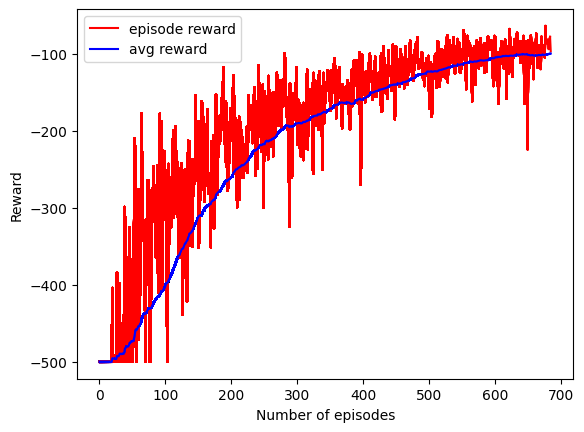

In [7]:
# Main training loop
# Record starting time
start = timer()

# for max_ep of episodes...
for i in range(max_ep):
    # reset environment and get initial state
    state = env.reset()[0]
    state = torch.tensor(state, dtype=torch.float32)
    # reset time step count and episode reward
    num_step = 0
    ep_reward = 0
    # collecting transitions until the episode ends...
    while True:
        # epsilon greedy
        num = random.random()
        if num <= epsilon:
            # action space is (0, 1, 2)
            action = random.randint(0, 2)
        else:
            action = dqn.select_action(state).item()
        # apply action and get transition info
        next_state, reward, terminated, truncated, info = env.step(action)
        next_state = torch.tensor(next_state, dtype=torch.float32)
        done = terminated or truncated
        # store transition
        dqn.store(state, action, reward, next_state, done)
        # train and calculate loss
        loss = dqn.train()
        losses.append(loss)
        state = next_state
        ep_reward += reward
        # update target network after certain number of time steps
        if num_step % update_freq == 0:
            dqn.update_target()
        if done:
            break
        num_step += 1
    ep_rewards.append(ep_reward)
    avg_reward = np.mean(ep_rewards[-100:])
    avg_rewards.append(avg_reward)
    # decrement epsilon as the model gets stable
    epsilon = max(epsilon - epsilon_discount, epsilon_min)
    print("Episode {}:  {}   {}".format(i+1, ep_reward, avg_reward))
    rangeLst.append(i + 1)
    # print(rangeLst)
    # print(ep_rewards)
    plt.plot(rangeLst, ep_rewards[:i+1], 'r', label='episode reward')
    plt.plot(rangeLst, avg_rewards[:i+1], 'b', label='avg reward')
    if i == 0:
      plt.legend()
    plt.ylabel('Reward')
    plt.xlabel('Number of episodes')
    display.display(plt.gcf())
    display.clear_output(wait=True)
    time.sleep(1)

    if avg_reward >= env.spec.reward_threshold:
        print("Solved!")
        num_ep = i + 1
        dqn.save_weights('weights.h5')
        break
    if i == max_ep - 1:
        print('Maximum number of episodes reached. Not solved.')
        num_ep = i + 1
        dqn.save_weights('weights.h5')
        break
end = timer()

Training time: 2748.7670989


Text(0.5, 0, 'Time step')

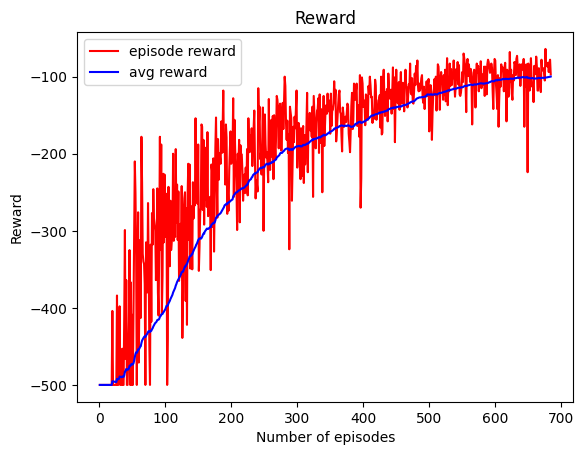

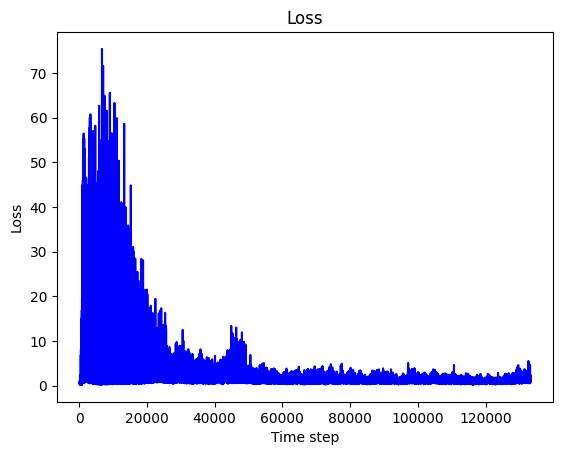

In [8]:
print('Training time: {}'.format(end - start))

# Plot rewards
plt.figure()
plt.plot(rangeLst, ep_rewards, 'r', label='episode reward')
plt.plot(rangeLst, avg_rewards, 'b', label='avg reward')
plt.title('Reward')
plt.legend()
plt.ylabel('Reward')
plt.xlabel('Number of episodes')

# Plot losses
plt.figure()
plt.title('Loss')
plt.plot(losses, 'b')
plt.ylabel('Loss')
plt.xlabel('Time step')

In [9]:
# Testing
test_ep = 10
for i in range(test_ep):
    state = env.reset()[0]
    state = torch.tensor(state, dtype=torch.float32)
    ep_reward = 0
    while True:
        # No exploration during testing
        action = dqn.select_action(state).item()
        next_state, reward, terminated, truncated, info = env.step(action)
        next_state = torch.tensor(next_state, dtype=torch.float32)
        done = terminated or truncated
        state = next_state
        ep_reward += reward
        if done:
            break
    print('Episode {} reward: {}'.format(i+1, ep_reward))

Episode 1 reward: -71.0
Episode 2 reward: -70.0
Episode 3 reward: -62.0
Episode 4 reward: -63.0
Episode 5 reward: -69.0
Episode 6 reward: -75.0
Episode 7 reward: -70.0
Episode 8 reward: -80.0
Episode 9 reward: -72.0
Episode 10 reward: -80.0
